In [1]:
import sys
import os
from transformers import CLIPTokenizer
from diffusers import LMSDiscreteScheduler
import numpy as np
from PIL import Image
from controlnet_aux import OpenposeDetector
import openvino as ov

c:\Users\chuxd\miniconda3\envs\ov_sd_controlnet\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\chuxd\miniconda3\envs\ov_sd_controlnet\Lib\site-packages\controlnet_aux\mediapipe_face\mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(
c:\Users\chuxd\miniconda3\envs\ov_sd_controlnet\Lib\site-packages\controlnet_aux\segment_anything\modeling\tiny_vit_sam.py:654: UserWarning: Overwriting tiny_vit_5m_224 in registry with controlnet_aux.segment_anything.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
c:\Users\chuxd\minicon

In [2]:
module_path = os.path.abspath(os.path.join('../detectors/scripts'))
if module_path not in sys.path:
    sys.path.append(module_path)
from ov_pipelines import OpenPoseOVModel, OVContrlNetStableDiffusionPipeline

In [3]:
ov_pipe = None
pose_estimator = None
def run_python_pipeline(prompt, negative_prompt, seed, steps, model_path, device, input_image, output_image):
    global ov_pipe
    global pose_estimator
    if ov_pipe is None and pose_estimator is None:
        pose_estimator = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")
        OPENPOSE_OV_PATH = os.path.join(model_path, "openpose.xml")
        CONTROLNET_OV_PATH = os.path.join(model_path, "controlnet-pose.xml")
        UNET_OV_PATH = os.path.join(model_path, "unet_controlnet.xml")
        TEXT_ENCODER_OV_PATH = os.path.join(model_path, "text_encoder.xml")
        VAE_DECODER_OV_PATH = os.path.join(model_path, "vae_decoder.xml")

        core = ov.Core()
        ov_openpose = OpenPoseOVModel(core, OPENPOSE_OV_PATH, device=device)
        pose_estimator.body_estimation.model = ov_openpose

        tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")

        scheduler_config = {"num_train_timesteps": 1000, "beta_start": 0.00085, "beta_end": 0.012, "beta_schedule": "scaled_linear", "prediction_type": "epsilon"}
        scheduler = LMSDiscreteScheduler.from_config(scheduler_config)
        ov_pipe = OVContrlNetStableDiffusionPipeline(
            tokenizer,
            scheduler,
            core,
            CONTROLNET_OV_PATH,
            TEXT_ENCODER_OV_PATH,
            UNET_OV_PATH,
            VAE_DECODER_OV_PATH,
            device=device,
        )


    img = Image.open(input_image)

    np.random.seed(seed)

    pose = pose_estimator(img)

    result = ov_pipe(prompt, pose, steps, negative_prompt=negative_prompt)

    res = result[0]
    res.save(output_image)
    return ov_pipe.init_latent, ov_pipe.init_latent_sigma, ov_pipe.init_noise_sigma

def run_cpp_pipeline(prompt, negative_prompt, seed, steps, model_path, device, input_image, output_image, latent_path):
    import subprocess
    # copy openvino dlls and opencv dlls and tbb12 dlls to ../build/Release/
    # or make sure they're in path
    command = [
        "../build/Release/stable_diffusion_controlnet.exe", 
        "-p", prompt,
        "-n", negative_prompt,
        "-i", input_image, 
        "-o", output_image, 
        "-m" ,model_path, 
        "-s", str(seed), 
        "--step", str(steps),
        "-d", device, 
        "-l", latent_path,
        "-c",
        ]
    result = subprocess.run(command, capture_output=True, text=True, cwd=".")
    print(f"stdout: {result.stdout}")
    print(f"stderr: {result.stderr}")

In [4]:
prompt = "Dancing Darth Vader, best quality, extremely detailed"
negative_prompt = "monochrome, lowres, bad anatomy, worst quality, low quality"
input_image = "pose.png"
steps = 20

# differencet seeds will causing different lantent
seeds = [40 + x for x in range(10)]
model_path = os.path.abspath(os.path.join('../models'))
device = "GPU.1"

latent, latent_with_sigma, init_noise_sigma = None, None, None
for seed in seeds:
    output_image = os.path.join('./images', f"output_{seed}_py.png")
    latent, latent_with_sigma, init_noise_sigma = run_python_pipeline(prompt, negative_prompt, seed, steps, model_path, device, input_image, output_image)
    latent_path = os.path.join('./images', f"latent_{seed}.txt")
    latent_sigma_path = os.path.join('./images', f"latent_{seed}.sigma.txt")
    init_noise_sigma_path = os.path.join('./images', f"sigma_{seed}.txt")
    np.savetxt(latent_path, latent, fmt='%.8e')
    # np.savetxt(latent_sigma_path, latent_with_sigma.flatten(), fmt='%.8e')
    # print(init_noise_sigma)

c:\Users\chuxd\miniconda3\envs\ov_sd_controlnet\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\chuxd\miniconda3\envs\ov_sd_controlnet\Lib\site-packages\diffusers\configuration_utils.py:139: FutureWarning: Accessing config attribute `unet` directly via 'OVContrlNetStableDiffusionPipeline' object attribute is deprecated. Please access 'unet' over 'OVContrlNetStableDiffusionPipeline's config object instead, e.g. 'scheduler.config.unet'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


14.614646911621094


  0%|          | 0/20 [00:00<?, ?it/s]c:\Users\chuxd\miniconda3\envs\ov_sd_controlnet\Lib\site-packages\diffusers\configuration_utils.py:139: FutureWarning: Accessing config attribute `controlnet` directly via 'OVContrlNetStableDiffusionPipeline' object attribute is deprecated. Please access 'controlnet' over 'OVContrlNetStableDiffusionPipeline's config object instead, e.g. 'scheduler.config.controlnet'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
100%|██████████| 20/20 [00:04<00:00,  4.78it/s]


14.614646911621094


100%|██████████| 20/20 [00:04<00:00,  4.86it/s]


14.614646911621094


100%|██████████| 20/20 [00:04<00:00,  4.84it/s]


14.614646911621094


100%|██████████| 20/20 [00:04<00:00,  4.77it/s]


14.614646911621094


100%|██████████| 20/20 [00:04<00:00,  4.80it/s]


14.614646911621094


100%|██████████| 20/20 [00:04<00:00,  4.94it/s]


14.614646911621094


100%|██████████| 20/20 [00:04<00:00,  4.91it/s]


14.614646911621094


100%|██████████| 20/20 [00:04<00:00,  4.93it/s]


14.614646911621094


100%|██████████| 20/20 [00:04<00:00,  4.94it/s]


14.614646911621094


100%|██████████| 20/20 [00:04<00:00,  4.94it/s]


In [5]:
for seed in seeds:
    # run cpp pipeline
    output_image = os.path.join('./images', f"output_{seed}_cpp.bmp")
    latent_path = os.path.join('./images', f"latent_{seed}.txt")
    run_cpp_pipeline(
        prompt, negative_prompt, seed, steps, model_path, device, input_image,output_image,latent_path
    )

stdout: OpenVINO version: OpenVINO Runtime
    Version : 2024.2.0
    Build   : 2024.2.0-15519-5c0f38f83f6-releases/2024/2

Loading and compiling text encoder: 2457.07 ms
Loading and compiling UNet: 7719.24 ms
Loading and compiling Detector: Loading model from: c:\Users\chuxd\repos\openvino.genai\image_generation\stable_diffusion_1_5_controlnet\cpp\models/openpose.xml
322.807 ms
Loading and compiling Controlnet: 3637.56 ms
Loading and compiling VAE decoder: 1094.07 ms
Loading and compiling tokenizer: 39.9299 ms
Running Stable Diffusion pipeline: Running inference
image_width: 512, image_height768
pad_width: 171, pad_height0
running 1/20
running 2/20
running 3/20
running 4/20
running 5/20
running 6/20
running 7/20
running 8/20
running 9/20
running 10/20
running 11/20
running 12/20
running 13/20
running 14/20
running 15/20
running 16/20
running 17/20
running 18/20
running 19/20
running 20/20
6344.74 ms

stderr: 
stdout: OpenVINO version: OpenVINO Runtime
    Version : 2024.2.0
    Build 

In [6]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def diff_image(image1, image2):
    img1 = np.array(image1).astype(float)
    img2 = np.array(image2).astype(float)
    
    diff = np.abs(img1 - img2)
    
    # average difference per channel
    channel_diffs = np.mean(diff, axis=(0, 1))
    
    # normalize difference
    normalized_diff = diff / np.max(diff)
    
    # total difference
    total_diff = np.mean(normalized_diff, axis=2)
    
    # plt.figure(figsize=(10, 5))
    
    # plt.subplot(121)
    # plt.imshow(total_diff, cmap='hot')
    # plt.colorbar()
    # plt.title("Difference Heatmap")
    
    # plt.subplot(122)
    # plt.imshow(total_diff, cmap='gray')
    # plt.colorbar()
    # plt.title("Difference Grayscale")
    
    # plt.tight_layout()
    # plt.show()
    
    return channel_diffs, total_diff

# output_image_cpp = Image.open(os.path.join('./images', f"output_40_cpp.bmp"))
# output_image_py = Image.open(os.path.join('./images', f"output_40_py.png"))


# channel_diffs, total_diff = diff_image(output_image_cpp, output_image_py)
# print("Channel differences:", channel_diffs)

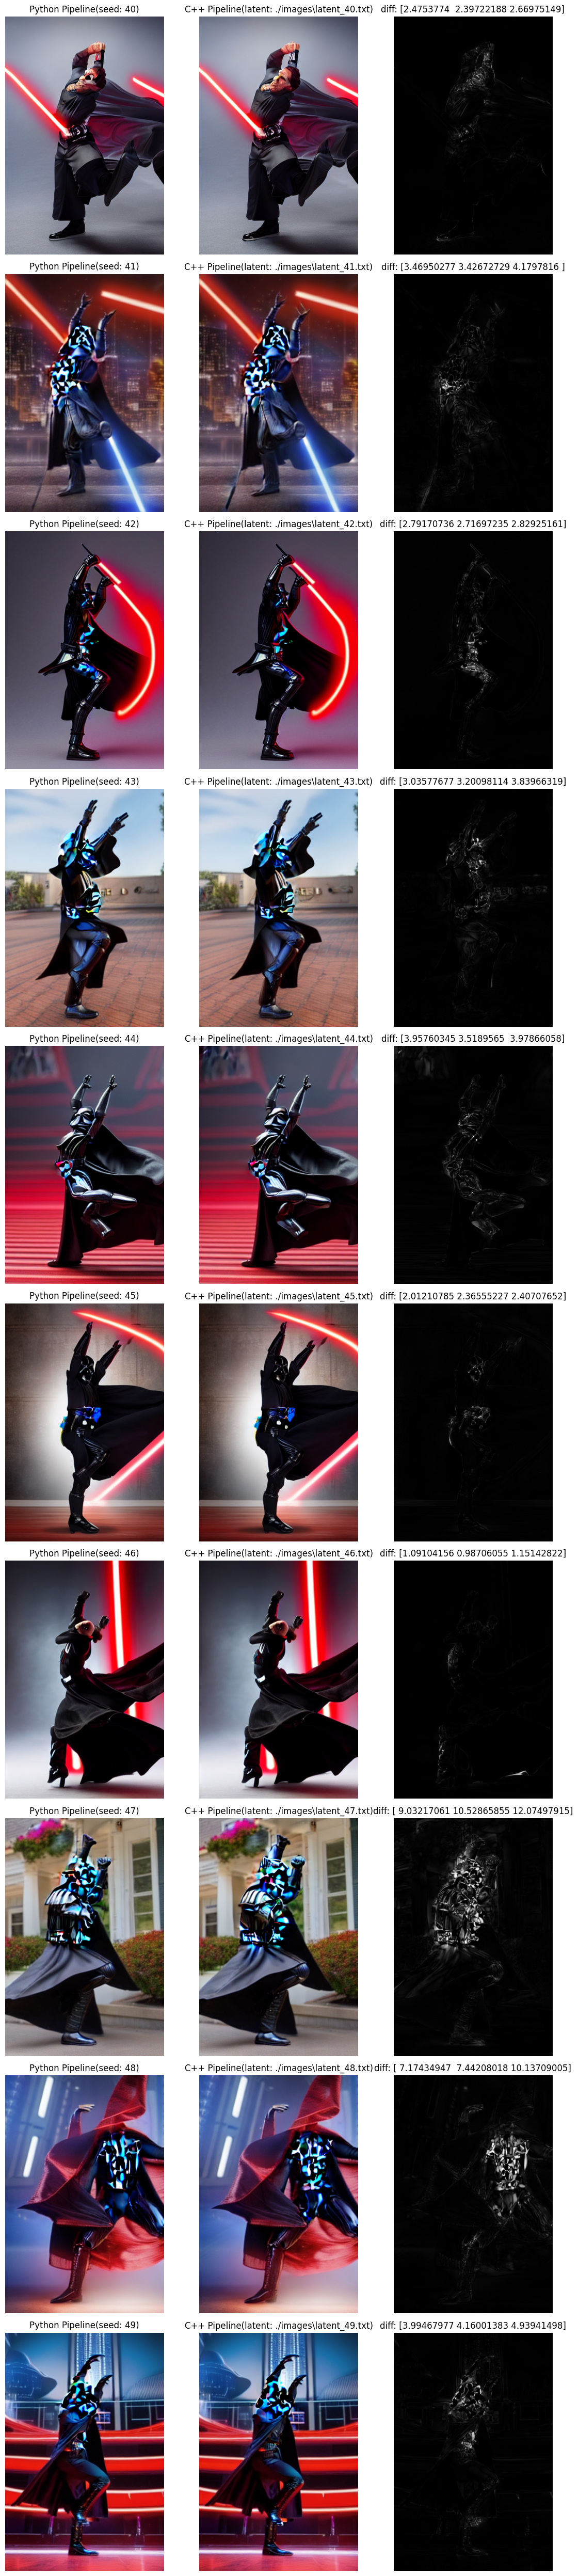

In [7]:
def display_images(seeds):
    import matplotlib.pyplot as plt
    from PIL import Image

    num_images = len(seeds)
    fig, axes = plt.subplots(num_images, 3, figsize=(12, 5 * num_images))

    for i, data in enumerate(seeds):
        seed = seeds[i]
        output_image_cpp = Image.open(os.path.join('./images', f"output_{seed}_cpp.bmp"))
        output_image_py = Image.open(os.path.join('./images', f"output_{seed}_py.png"))
        channel_diffs, total_diff = diff_image(output_image_cpp, output_image_py)
        latent_path = os.path.join('./images', f"latent_{seed}.txt")

        if num_images == 1:
            ax = axes
        else:
            ax = axes[i]
        
        # Display original image
        ax[0].imshow(output_image_py)
        ax[0].set_title(f"Python Pipeline(seed: {seed})")
        ax[0].axis('off')
        
        # Display C++ result image
        ax[1].imshow(output_image_cpp)
        ax[1].set_title(f"C++ Pipeline(latent: {latent_path})")
        ax[1].axis('off')
        
        # Display diff
        ax[2].imshow(total_diff, cmap='gray')
        ax[2].set_title(f"diff: {channel_diffs}")
        ax[2].axis('off')
        

    plt.tight_layout()
    plt.show()

display_images(seeds)